In [2]:
import glob
from pathlib import Path
import os

from jax.config import config
import jax.numpy as jnp
from jax.nn import softmax
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from grl.utils import load_info
from definitions import ROOT_DIR
config.update('jax_platform_name', 'cpu')


In [3]:
def test_mem_matrix(mem_params: jnp.ndarray, test_preserving: bool = True, mse: bool = False):
    """
    Tests the memory matrix for t-maze.
    our tolerance is set to 1e-1, which seems high, but should be fine for
    stochastic matrices that we have.
    """
    NORTH, SOUTH, EAST, WEST = list(range(4))
    UP_START = 0
    DOWN_START = 1
    CORRIDOR = 2
    JUNCTION = 3

    mem_func = softmax(mem_params, axis=-1)
    right_mem_func = mem_func[EAST]

    # we index by zero here, since memory starts at 0
    right_up_start = right_mem_func[UP_START, 0]
    right_down_start = right_mem_func[DOWN_START, 0]

    # we test whether start bits set to different memory states
    def test_start_bits_set(right_up_start: np.ndarray, right_down_start: np.ndarray):
        res = np.abs(right_up_start - right_down_start).sum() / 2
        if mse:
            return (res - 1)**2
        else:
            return np.isclose(res, 1, atol=1e-1)

    diff_start_bits_set = test_start_bits_set(right_up_start, right_down_start)

    # now we test whether the right corridor memory function is all set or reset
    right_corridor = right_mem_func[CORRIDOR]

    def test_corridor_hold_or_toggle(right_corridor: np.ndarray):
        if mse:
            is_toggle = ((right_corridor - np.eye(2)[:, ::-1])**2).mean().item()
            is_hold = ((right_corridor - np.eye(2))**2).mean().item()
            return is_toggle, is_hold
        else:
            is_toggle = np.allclose(right_corridor, np.eye(2)[:, ::-1], atol=1e-1)
            is_hold = np.allclose(right_corridor, np.eye(2), atol=1e-1)
            return is_toggle, is_hold

    def test_memory_preserving(mem: np.ndarray):
        # everything that's not part of the optimal policy
        # ie. check for memory preserving functions
        corridor_bumps = mem[[NORTH, SOUTH], CORRIDOR]
        corridor_left = mem[[WEST], CORRIDOR]

        junction_bumps = mem[[EAST], JUNCTION]
        junction_left = mem[[WEST], JUNCTION]
        all_checks = {'corridor_bumps': corridor_bumps, 'corridor_left': corridor_left, 'junction_bumps': junction_bumps, 'junction_left': junction_left}
        if mse:
            mses = []
            for check in all_checks.values():
                mses.append(((check - np.eye(2))**2).mean().item())
            return sum(mses) / len(mses), all_checks
        else:
            is_preserving = np.allclose(np.concatenate(tuple(all_checks.values()), axis=0), np.eye(2), atol=1e-2)
            return is_preserving, all_checks

    is_toggle, is_hold = test_corridor_hold_or_toggle(right_corridor)
    
    if mse:
        is_optimal = 0.5 * diff_start_bits_set + 0.5 * min(is_toggle, is_hold)
    else:
        is_optimal = diff_start_bits_set and (is_toggle or is_hold)
        
    additional_info = {'diff_start_bits_set': diff_start_bits_set, 'is_toggle': is_toggle, 'is_hold': is_hold}
    if test_preserving:
        is_preserving, all_preserving_checks = test_memory_preserving(mem_func)

        if mse:
            is_optimal = 1/3 * (diff_start_bits_set + min(is_toggle, is_hold) + 2 * is_preserving)
        else:
            is_optimal = is_optimal and is_preserving
        additional_info.update(all_preserving_checks)
        additional_info['is_preserving'] = is_preserving

    return is_optimal, additional_info


In [4]:
def load_sampled_results(pathname: str, use_epsilon: bool = False):
    all_results = []
    results_dirs = glob.glob(pathname)
    for results_dir in results_dirs:
        results_file = results_dir + '/info.npy'
        if not os.path.exists(results_file):
            continue
        info = load_info(results_file)
        final_mem_params = info['final_params']
        is_optimal, mem_info = test_mem_matrix(final_mem_params, test_preserving=use_epsilon)
        result = {
            'policy_up_prob': info['policy_up_prob'],
            'policy_epsilon': info['policy_epsilon'] if 'policy_epsilon' in info else np.nan,
            'trial_id': os.path.basename(results_dir).split('__')[0].split('_')[-1],
            'initial_discrep': info['initial_discrep'],
            'final_discrep': info['final_discrep'],
            'is_optimal': is_optimal
        }
        all_results.append(result)
    data = pd.DataFrame(all_results)
    return data


In [5]:
def load_analytical_results(pathname: str, use_epsilon=False, mse=False):
    results_dir = Path(ROOT_DIR, pathname)

    def aggregate_q_discrep(q_discrep, policy):
        return (q_discrep.T * policy).sum(-1).mean()

    all_results = []
    for results_path in results_dir.iterdir():
        if results_path.suffix != '.npy':
            continue
        info = load_info(results_path)
        args = info['args']
        
        if args['mem_leakiness'] > 0.1:
            continue

        policy_up_prob = args['tmaze_junction_up_pi']
        policy_epsilon = args['epsilon'] if 'epsilon' in args else np.nan

        grad_info = info['logs']
        args = info['args']
        agent_info = load_info(results_path.parent/'agents'/f'{results_path.stem}.pkl.npy')
        final_mem_params = agent_info.mem_params
        is_optimal, additional_checks = test_mem_matrix(final_mem_params, test_preserving=use_epsilon, mse=mse)

        initial_q_discrep = grad_info['initial_mem_stats']['discrep'].item()
        final_q_discrep = grad_info['final_mem_stats']['discrep'].item()

        result = {
            'policy_up_prob': policy_up_prob,
            'policy_epsilon': policy_epsilon,
            'mem_id': args['use_memory'],
            'leak': args['mem_leakiness'],
            'trial_id': os.path.basename(results_path).split('_s(')[-1].split(')_')[0],
            'seed': args['seed'],
            # 'initial_discrep': initial_v_discrep.mean(),
            # 'final_discrep': final_v_discrep.mean(),
            'initial_discrep': initial_q_discrep,
            'final_discrep': final_q_discrep,
            'is_optimal': is_optimal,
            'is_preserving': additional_checks['is_preserving'],
            'is_optimal_less_preserving': 0.5 * (additional_checks['diff_start_bits_set'] + min(additional_checks['is_toggle'], additional_checks['is_hold']))
        }
        all_results.append(result)
    data = pd.DataFrame(all_results)
    return data


In [6]:
def plot_sweep(data: pd.DataFrame, x='policy_up_prob', ax=None, title=None, add_colorbar=False):
    y_high = max(data['initial_discrep'].max(), data['final_discrep'].max()) * 1.05
    y_low = 0
    x_high = max(data[x])
    x_low = min(data[x])

    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 5))
    data_seed_avg = data.groupby(x, as_index=False).mean()
    aximg = ax.imshow(
        data_seed_avg['is_optimal'].to_numpy()[None, :],
        vmin=0,
        vmax=1,
        extent=(x_low, x_high, y_low, y_high),
        cmap='RdYlBu',
        aspect='auto',
        alpha=0.5,
    )
    if add_colorbar:
        plt.gcf().colorbar(aximg,
                           label='Optimal memory frequency',
                           ticks=[0.0, 0.5, 1.0],
                           format='%0.1f')
    sns.lineplot(data=data, x=x, y='initial_discrep', color='blue', ax=ax, label='Initial')
    sns.lineplot(data=data, x=x, y='final_discrep', color='black', ax=ax, label='Final')
    ax.legend()
    ax.set_ylabel('Aggregated λ-discrep')
    ax.set_xlabel(x)
    ax.set_title(title)
    plt.gcf().tight_layout()
    plt.gcf().subplots_adjust(right=0.75)


In [7]:
# planning_data = load_analytical_results(str(Path(ROOT_DIR, 'results', 'tmaze_sweep_junction_pi')))
# learning_data = load_sampled_results(
#     str(Path(ROOT_DIR, 'results', 'junction-up-prob-lambda999-6', 'tmaze_5_two_thirds_up/*')))
planning_data = load_analytical_results(str(Path(ROOT_DIR, 'results', 'tmaze_sweep_eps_leaky')), use_epsilon=True, mse=True)
# learning_data = load_sampled_results(
#     str(Path(ROOT_DIR, 'results', 'sweep-up-prob-imp-samp-7', 'tmaze_5_two_thirds_up/*')))

# np.set_printoptions(precision=4)
# plt.rcParams['axes.facecolor'] = 'white'
# plt.rcParams.update({'font.size': 14})
# leaks = planning_data['leak'].unique()
# leaks.sort()
# for leak in leaks:
#     fig, axes = plt.subplots(1, 1, figsize=(12, 5))
#     plot_sweep(planning_data[planning_data['leak'] == leak], ax=axes, title=f'Planning Agent, leak={leak:.2f}', add_colorbar=False)
#     axes.set_xlim(0,0.5)
# plot_sweep(learning_data, ax=axes[1], title='Learning Agent', add_colorbar=True)
# learning_data[learning_data['policy_up_prob'] == 0]

mean_df = planning_data.groupby(['policy_epsilon', 'leak'], as_index=False).mean()


/var/folders/df/_1rc7wjx4vz7khl5ndgl3k2w0000gn/T/ipykernel_77109/1584354498.py:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df = planning_data.groupby(['policy_epsilon', 'leak'], as_index=False).mean()


/var/folders/df/_1rc7wjx4vz7khl5ndgl3k2w0000gn/T/ipykernel_77109/12477807.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  g = sns.heatmap(mean_df.pivot('policy_epsilon', 'leak', 'is_optimal'), cmap='viridis_r')


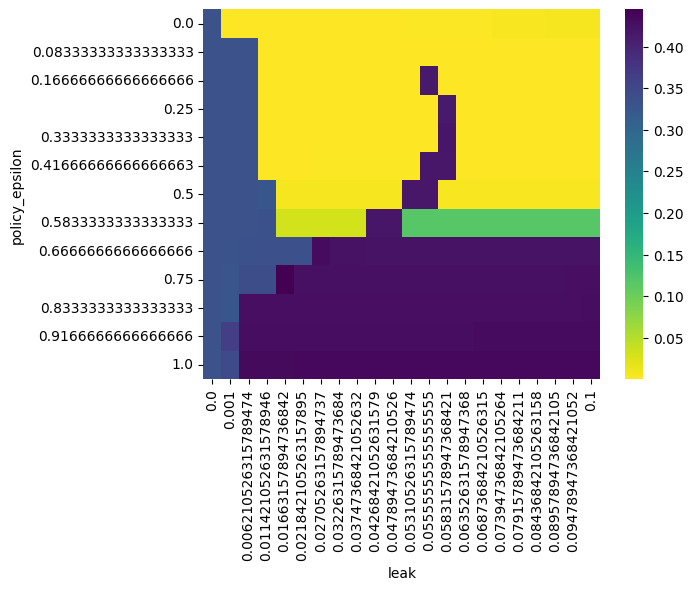

In [8]:
g = sns.heatmap(mean_df.pivot('policy_epsilon', 'leak', 'is_optimal'), cmap='viridis_r')
# planning_data['is_optimal']

/var/folders/df/_1rc7wjx4vz7khl5ndgl3k2w0000gn/T/ipykernel_77109/742576139.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  g = sns.heatmap(mean_df.pivot('policy_epsilon', 'leak', 'is_preserving'), xticklabels=10, yticklabels=10, cmap='viridis_r')


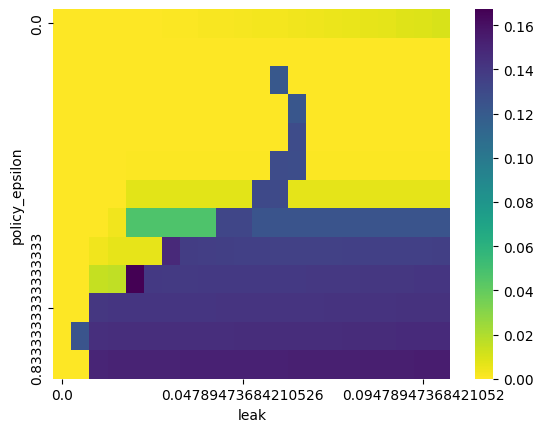

In [9]:
g = sns.heatmap(mean_df.pivot('policy_epsilon', 'leak', 'is_preserving'), xticklabels=10, yticklabels=10, cmap='viridis_r')


In [ ]:
# planning_data = load_analytical_results(pathname=str(Path(ROOT_DIR, 'results', 'tmaze_sweep_eps')), use_epsilon=True)
# learning_data = load_sampled_results(
#     str(Path(ROOT_DIR, 'results', 'junction-sweep-eps-lambda999-03', 'tmaze_5_two_thirds_up/*')))
planning_data = load_analytical_results(pathname=str(Path(ROOT_DIR, 'results', 'tmaze_sweep_eps_leaky')), use_epsilon=True)
# learning_data = load_sampled_results(
#     str(Path(ROOT_DIR, 'results', 'sweep-eps-imp-samp-04', 'tmaze_5_two_thirds_up/*')))

leaks = planning_data['leak'].unique()
leaks.sort()
fig, axes = plt.subplots(1, 1, figsize=(8, 5))
for leak in leaks:
    plot_sweep(planning_data[planning_data['leak'] == leak], ax=axes, x='policy_epsilon', title=f'Planning Agent, leak={leak:.2f}', add_colorbar=False)
# plot_sweep(learning_data, ax=axes[1], x='policy_epsilon', title='Learning Agent', add_colorbar=True)


In [ ]:
fig, ax = plt.subplots()
plt.plot()
sns.lineplot(data=planning_data, ax=ax, x='policy_epsilon', y='initial_discrep', color='blue', linestyle='-', label='Initial, Planning')
sns.lineplot(data=learning_data, ax=ax, x='policy_epsilon', y='initial_discrep', color='blue', linestyle='--', label='Initial, Learning')
sns.lineplot(data=planning_data, ax=ax, x='policy_epsilon', y='final_discrep', color='black', linestyle='-', label='Final, Planning')
sns.lineplot(data=learning_data, ax=ax, x='policy_epsilon', y='final_discrep', color='black', linestyle='--', label='Final, Learning')


In [ ]:
planning_data = load_analytical_results('results/analytical/tmaze_sweep_junction_pi_2022-02-17')
learning_data = load_sampled_results(
    'results/sample_based/junction-sweep-up-prob-5/tmaze_5_two_thirds_up/*')

fig, ax = plt.subplots()
plt.plot()
sns.lineplot(data=planning_data, ax=ax, x='policy_up_prob', y='initial_discrep', color='blue', linestyle='-', label='Initial, Planning')
sns.lineplot(data=learning_data, ax=ax, x='policy_up_prob', y='initial_discrep', color='blue', linestyle='--', label='Initial, Learning')
sns.lineplot(data=planning_data, ax=ax, x='policy_up_prob', y='final_discrep', color='black', linestyle='-', label='Final, Planning')
sns.lineplot(data=learning_data, ax=ax, x='policy_up_prob', y='final_discrep', color='black', linestyle='--', label='Final, Learning')
plt.legend()